# **Import packages**

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from PIL import Image
import numpy as np
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import torch.optim as optim
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, precision_score, recall_score, f1_score, classification_report
import os
import pandas as pd
import copy
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.manifold import TSNE
from torchvision.models import resnet18, ResNet18_Weights
from torchvision import transforms, models
from sklearn.preprocessing import StandardScaler
import itertools
from sklearn.preprocessing import MinMaxScaler
import time
from tqdm import tqdm
import torch.nn.functional as F
from pathlib import Path
import seaborn as sns

# 皮膚癌的分類圖

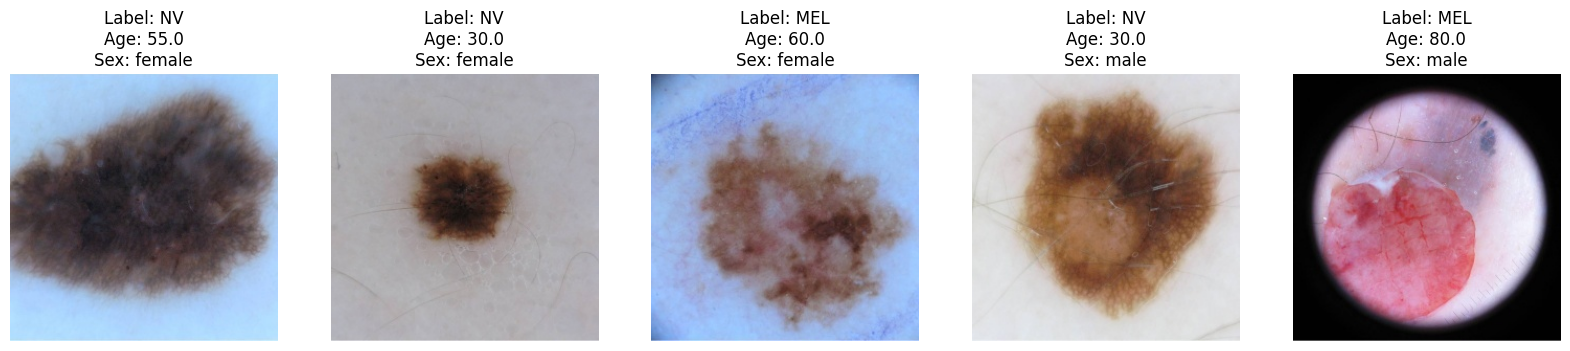

In [2]:
data_dir = '/kaggle/input/jpeg-isic2019-256x256/train'
metadata_file = '/kaggle/input/jpeg-isic2019-256x256/train.csv'


metadata = pd.read_csv(metadata_file)

# 檢查文件名擴展名
def get_image_path(filename):
    return f"{data_dir}/{filename}.jpg"

# 構建圖像路徑
train_paths = [get_image_path(fname) for fname in metadata['image_name']]
train_labels = metadata['diagnosis']  
train_ages = metadata['age_approx']
train_sexes = metadata['sex']

# 設置圖像轉換
transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
])


num_samples = 5  
fig, axes = plt.subplots(1, num_samples, figsize=(20, 5))

for i in range(num_samples):
    img_path = train_paths[i]
    label = train_labels[i]
    age = train_ages[i]
    sex = train_sexes[i]

    
    if not os.path.isfile(img_path):
        print(f"File not found: {img_path}")
        continue

    # 下載
    img = Image.open(img_path).convert('RGB')
    img = transform(img)
    
    
    img = img.permute(1, 2, 0).numpy()

    # 顯示圖像
    axes[i].imshow(img)
    axes[i].set_title(f'Label: {label}\nAge: {age}\nSex: {sex}')
    axes[i].axis('off')

plt.show()


# 數據預處理
增強數據&分割成訓練集,驗證集以及測試集

/tmp/ipykernel_34/1219389834.py:9: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  metadata['age_approx'].fillna(metadata['age_approx'].mean(), inplace=True)


Total samples after augmentation: 29853
Training set size: 17911
Validation set size: 5971
Test set size: 5971


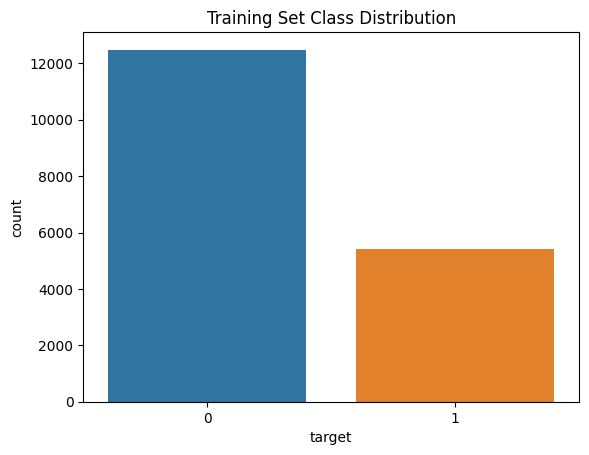

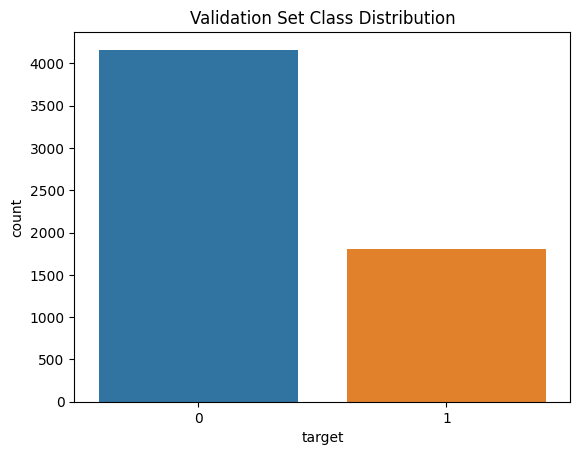

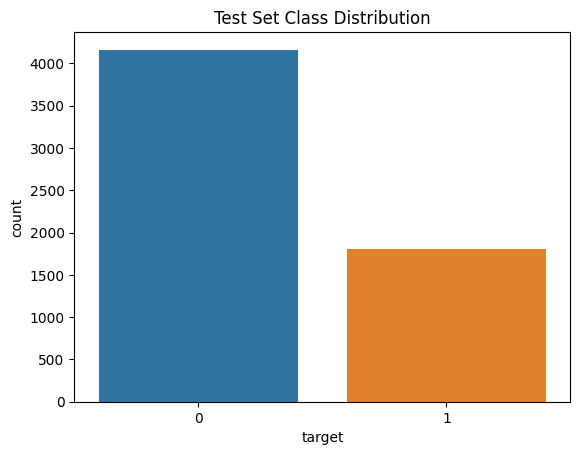

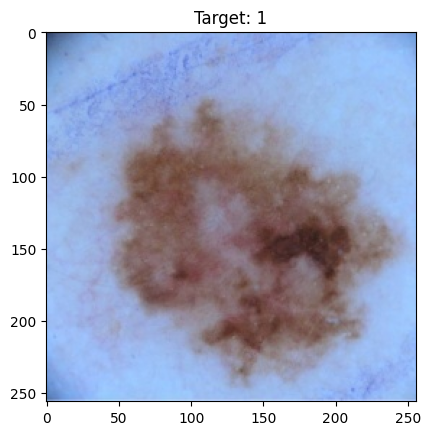

In [3]:
# 讀取包含圖像名稱、目標標籤和年齡信息的 CSV 文件
metadata_path = '/kaggle/input/jpeg-isic2019-256x256/train.csv'  
metadata = pd.read_csv(metadata_path)

# 圖像文件的根目錄
image_root = Path('/kaggle/input/jpeg-isic2019-256x256/train')

# 處理 NaN 值
metadata['age_approx'].fillna(metadata['age_approx'].mean(), inplace=True)

# 使用 MinMaxScaler 將數據標準化到 -1 和 1 之間
scaler = MinMaxScaler(feature_range=(-1, 1))
metadata['age_approx'] = scaler.fit_transform(metadata[['age_approx']])

# 分離多數類別 (0) 和少數類別 (1)
majority_class = metadata[metadata['target'] == 0]
minority_class = metadata[metadata['target'] == 1]

# 增強後的圖像保存目錄
output_folder = Path('/kaggle/working/augmented_images')
output_folder.mkdir(exist_ok=True)

# 對少數類別進行水平翻轉數據增強
augmented_images = []
augmented_labels = []
augmented_ages = []

for idx, row in minority_class.iterrows():
    image_name = row['image_name']
    age = row['age_approx']
    label = row['target']
    
    # 完整的圖像路徑
    image_path = image_root / f"{image_name}.jpg"
    
    # 打開圖像
    image = Image.open(image_path)
    
    # 原圖和翻轉圖
    flipped_image = image.transpose(Image.FLIP_LEFT_RIGHT)
    
    # 保存翻轉圖像到可寫目錄
    flipped_image_path = output_folder / f"{image_name}_flipped.jpg"
    flipped_image.save(flipped_image_path)
    
    # 添加原圖和翻轉圖的信息
    augmented_images.extend([str(image_path), str(flipped_image_path)])
    augmented_labels.extend([label, label])
    augmented_ages.extend([age, age])  # 確保增加年齡數據

# 將增強後的數據與多數類別數據合併
augmented_metadata = pd.DataFrame({
    'image_path': augmented_images + majority_class['image_name'].apply(lambda x: str(image_root / f"{x}.jpg")).tolist(),
    'target': augmented_labels + majority_class['target'].tolist(),
    'age_approx': augmented_ages + majority_class['age_approx'].tolist()
})

# 打印增強後的數據集大小
print(f"Total samples after augmentation: {len(augmented_metadata)}")

# 分割數據集
train_metadata, temp_metadata = train_test_split(
    augmented_metadata, test_size=0.4, stratify=augmented_metadata['target'], random_state=42
)
val_metadata, test_metadata = train_test_split(
    temp_metadata, test_size=0.5, stratify=temp_metadata['target'], random_state=42
)

# 打印分割後的數據集大小
print(f"Training set size: {len(train_metadata)}")
print(f"Validation set size: {len(val_metadata)}")
print(f"Test set size: {len(test_metadata)}")

# 檢查數據集類別分佈
def plot_class_distribution(metadata, title):
    sns.countplot(data=metadata, x='target')
    plt.title(title)
    plt.show()

plot_class_distribution(train_metadata, "Training Set Class Distribution")
plot_class_distribution(val_metadata, "Validation Set Class Distribution")
plot_class_distribution(test_metadata, "Test Set Class Distribution")

# 檢查增強後的圖像
sample_image_path = augmented_metadata['image_path'].iloc[0]
sample_image = Image.open(sample_image_path)
plt.imshow(sample_image)
plt.title(f"Target: {augmented_metadata['target'].iloc[0]}")
plt.show()


#  模型

In [4]:
import torch
import torch.nn as nn
import torchvision.models as models
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image
import numpy as np

class SkinLesionDataset(Dataset):
    def __init__(self, metadata, transform=None):
        self.metadata = metadata
        self.transform = transform

    def __len__(self):
        return len(self.metadata)

    def __getitem__(self, idx):
        img_path = self.metadata.iloc[idx]['image_path']
        image = Image.open(img_path).convert('RGB')
        
        if self.transform:
            image = self.transform(image)
            
        target = self.metadata.iloc[idx]['target']
        age = self.metadata.iloc[idx]['age_approx']
        
        return image, torch.tensor(target, dtype=torch.long), torch.tensor(age, dtype=torch.float)

class CustomResNet(nn.Module):
    def __init__(self, num_classes=2):
        super(CustomResNet, self).__init__()
        
        # 載入預訓練的ResNet50
        self.resnet = models.resnet50(pretrained=True)
        
        # 凍結前幾層
        for param in list(self.resnet.parameters())[:-20]:
            param.requires_grad = False
            
        # 修改最後的全連接層，加入年齡特徵
        num_features = self.resnet.fc.in_features
        self.resnet.fc = nn.Identity()  # 移除原始的fc層
        
        # 新增自定義層
        self.fusion = nn.Sequential(
            nn.Linear(num_features + 1, 512),  # +1 是為了年齡特徵
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(256, num_classes)
        )
        
    def forward(self, x, age):
        # 提取圖像特徵
        x = self.resnet(x)
        
        # 將圖像特徵與年齡特徵連接
        x = torch.cat([x, age.unsqueeze(1)], dim=1)
        
        # 通過融合層
        x = self.fusion(x)
        return x

def get_data_loaders(train_metadata, val_metadata, test_metadata, batch_size=32):
    # 定義數據轉換
    train_transform = transforms.Compose([
        transforms.Resize((256, 256)),
        transforms.RandomHorizontalFlip(),
        transforms.RandomVerticalFlip(),
        transforms.RandomRotation(10),
        transforms.ColorJitter(brightness=0.2, contrast=0.2),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], 
                           std=[0.229, 0.224, 0.225])
    ])
    
    val_transform = transforms.Compose([
        transforms.Resize((256, 256)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], 
                           std=[0.229, 0.224, 0.225])
    ])
    
    # 創建數據集
    train_dataset = SkinLesionDataset(train_metadata, transform=train_transform)
    val_dataset = SkinLesionDataset(val_metadata, transform=val_transform)
    test_dataset = SkinLesionDataset(test_metadata, transform=val_transform)
    
    # 創建數據加載器
    train_loader = DataLoader(train_dataset, batch_size=batch_size, 
                            shuffle=True, num_workers=4)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, 
                          shuffle=False, num_workers=4)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, 
                           shuffle=False, num_workers=4)
    
    return train_loader, val_loader, test_loader



# 訓練模型

In [5]:
def train_model(model, train_loader, val_loader, num_epochs=20):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model = model.to(device)
    
    # 使用交叉熵損失函數
    criterion = nn.CrossEntropyLoss()
    
    # 使用Adam優化器
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
    
    # 學習率調度器
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
        optimizer, mode='min', patience=5, factor=0.5, verbose=True
    )
    
    best_val_loss = float('inf')
    
    for epoch in range(num_epochs):
        # 訓練階段
        model.train()
        train_loss = 0
        for images, targets, ages in train_loader:
            images = images.to(device)
            targets = targets.to(device)
            ages = ages.to(device)
            
            optimizer.zero_grad()
            outputs = model(images, ages)
            loss = criterion(outputs, targets)
            loss.backward()
            optimizer.step()
            
            train_loss += loss.item()
            
        # 驗證階段
        model.eval()
        val_loss = 0
        correct = 0
        total = 0
        
        with torch.no_grad():
            for images, targets, ages in val_loader:
                images = images.to(device)
                targets = targets.to(device)
                ages = ages.to(device)
                
                outputs = model(images, ages)
                loss = criterion(outputs, targets)
                val_loss += loss.item()
                
                _, predicted = outputs.max(1)
                total += targets.size(0)
                correct += predicted.eq(targets).sum().item()
        
        # 計算平均損失和準確率
        train_loss = train_loss / len(train_loader)
        val_loss = val_loss / len(val_loader)
        accuracy = 100. * correct / total
        
        print(f'Epoch [{epoch+1}/{num_epochs}]')
        print(f'Train Loss: {train_loss:.4f}')
        print(f'Val Loss: {val_loss:.4f}')
        print(f'Val Accuracy: {accuracy:.2f}%')
        
        # 更新學習率
        scheduler.step(val_loss)
        
        # 保存最佳模型
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            torch.save(model.state_dict(), 'best_model.pth')


model = CustomResNet(num_classes=2)
train_loader, val_loader, test_loader = get_data_loaders(
    train_metadata, val_metadata, test_metadata
)
train_model(model, train_loader, val_loader)


/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 164MB/s]


Epoch [1/20]
Train Loss: 0.3767
Val Loss: 0.2994
Val Accuracy: 87.07%
Epoch [2/20]
Train Loss: 0.3246
Val Loss: 0.3076
Val Accuracy: 87.66%
Epoch [3/20]
Train Loss: 0.3083
Val Loss: 0.2830
Val Accuracy: 87.66%
Epoch [4/20]
Train Loss: 0.3013
Val Loss: 0.2773
Val Accuracy: 87.96%
Epoch [5/20]
Train Loss: 0.2944
Val Loss: 0.2698
Val Accuracy: 88.63%
Epoch [6/20]
Train Loss: 0.2836
Val Loss: 0.2700
Val Accuracy: 89.18%
Epoch [7/20]
Train Loss: 0.2718
Val Loss: 0.2635
Val Accuracy: 89.21%
Epoch [8/20]
Train Loss: 0.2627
Val Loss: 0.2527
Val Accuracy: 89.60%
Epoch [9/20]
Train Loss: 0.2517
Val Loss: 0.2706
Val Accuracy: 89.11%
Epoch [10/20]
Train Loss: 0.2481
Val Loss: 0.2678
Val Accuracy: 89.40%
Epoch [11/20]
Train Loss: 0.2386
Val Loss: 0.2597
Val Accuracy: 89.35%
Epoch [12/20]
Train Loss: 0.2342
Val Loss: 0.2478
Val Accuracy: 89.43%
Epoch [13/20]
Train Loss: 0.2270
Val Loss: 0.2485
Val Accuracy: 89.75%
Epoch [14/20]
Train Loss: 0.2223
Val Loss: 0.2471
Val Accuracy: 89.90%
Epoch [15/20]
T

# Confusion matrix

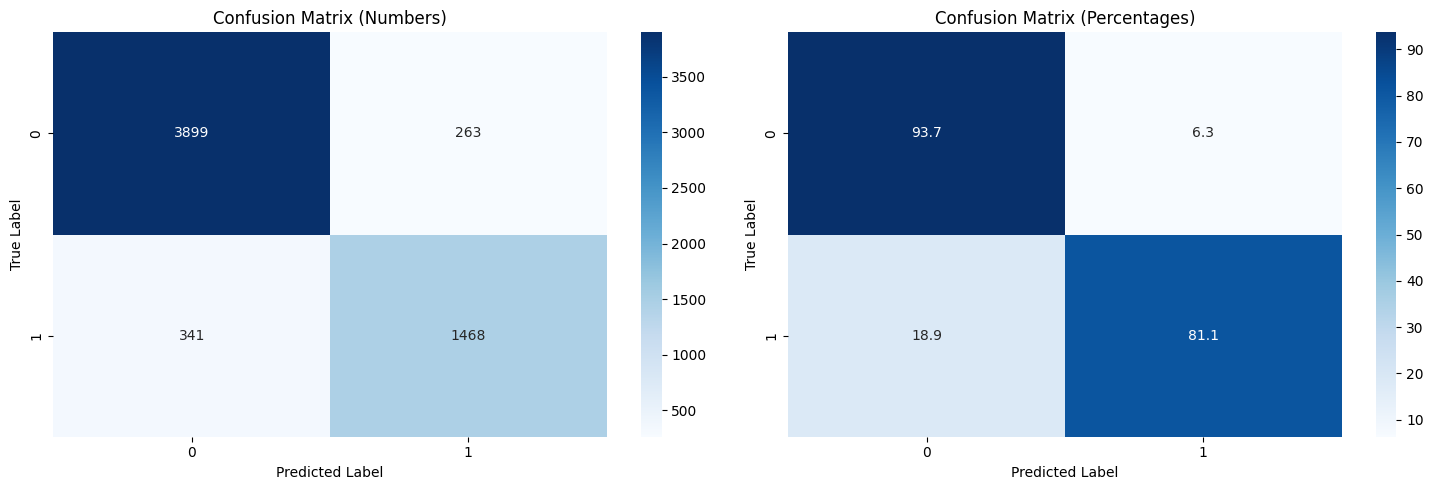


Accuracy: 89.88%
Sensitivity: 81.15%
Specificity: 93.68%


In [6]:
import torch
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

def evaluate_model_with_confusion_matrix(model, test_loader):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model.eval()
    all_predictions = []
    all_targets = []
    
    with torch.no_grad():
        for images, targets, ages in test_loader:
            images = images.to(device)
            ages = ages.to(device)
            outputs = model(images, ages)
            _, predictions = outputs.max(1)
            
            all_predictions.extend(predictions.cpu().numpy())
            all_targets.extend(targets.numpy())
    
    # 計算混淆矩陣
    cm = confusion_matrix(all_targets, all_predictions)
    
    # 計算百分比
    cm_percent = (cm / cm.sum(axis=1)[:, np.newaxis]) * 100
    
    # 創建圖形
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
    
    # 繪製數值混淆矩陣
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=ax1)
    ax1.set_title('Confusion Matrix (Numbers)')
    ax1.set_xlabel('Predicted Label')
    ax1.set_ylabel('True Label')
    
    # 繪製百分比混淆矩陣
    sns.heatmap(cm_percent, annot=True, fmt='.1f', cmap='Blues', ax=ax2)
    ax2.set_title('Confusion Matrix (Percentages)')
    ax2.set_xlabel('Predicted Label')
    ax2.set_ylabel('True Label')
    
    plt.tight_layout()
    plt.show()
    
    # 打印評估指標
    tn, fp, fn, tp = cm.ravel()
    accuracy = (tp + tn) / (tp + tn + fp + fn) * 100
    sensitivity = tp / (tp + fn) * 100
    specificity = tn / (tn + fp) * 100
    
    print(f'\nAccuracy: {accuracy:.2f}%')
    print(f'Sensitivity: {sensitivity:.2f}%')
    print(f'Specificity: {specificity:.2f}%')

# 直接使用已有的model進行評估
evaluate_model_with_confusion_matrix(model, test_loader)

# # 儲存模型

In [7]:
import torch
import json

def save_model_and_mapping():
    try:
        # 保存模型權重
        torch.save(model.state_dict(), 'best_model.pth')
        print("✓ 模型權重已保存")
        
        # 保存標籤映射
        label_mapping = {
            "0": "benign",    # 良性
            "1": "malignant"  # 惡性
        }
        with open('class_mapping.json', 'w') as f:
            json.dump(label_mapping, f, indent=4)
        print("✓ 標籤映射已保存")
        
        # 驗證保存的文件
        # 測試載入模型
        test_model = CustomResNet(num_classes=2)
        test_model.load_state_dict(torch.load('best_model.pth'))
        print("✓ 模型載入測試成功")
        
        # 測試載入標籤映射
        with open('class_mapping.json', 'r') as f:
            test_mapping = json.load(f)
        print("✓ 標籤映射載入測試成功")
        print(f"標籤映射內容: {test_mapping}")
        
    except Exception as e:
        print(f"保存過程出現錯誤: {str(e)}")
        return False
    
    return True

# 如果需要載入模型和映射
def load_model_and_mapping():
    try:
        # 創建模型實例
        model = CustomResNet(num_classes=2)
        
        # 載入權重
        model.load_state_dict(torch.load('best_model.pth'))
        
        # 載入標籤映射
        with open('class_mapping.json', 'r') as f:
            mapping = json.load(f)
            
        return model, mapping
        
    except Exception as e:
        print(f"載入錯誤: {str(e)}")
        return None, None

# 保存模型和映射
print("開始保存模型和映射...")
if save_model_and_mapping():
    print("\n所有文件保存和驗證成功！")
else:
    print("\n保存過程中出現錯誤，請檢查。")



開始保存模型和映射...
✓ 模型權重已保存
✓ 標籤映射已保存


/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


✓ 模型載入測試成功
✓ 標籤映射載入測試成功
標籤映射內容: {'0': 'benign', '1': 'malignant'}

所有文件保存和驗證成功！
